In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [206]:
df = pd.read_csv('./Social_Network_Ads.csv.xls')

In [207]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [231]:
# Check for null values
df.isna().sum()

Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

#### Removendo Colunas Desnecessárias

Antes de iniciar a análise, precisamos remover a coluna **User ID**. 

Essa coluna não é útil para nossas previsões, pois não fornece informações significativas relacionadas à variável alvo.

In [210]:
df = df.drop(['User ID'],axis=1)

In [211]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


In [234]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}\n")

Gender: [1 0]

Age: [19 35 26 27 32 25 20 18 29 47 45 46 48 49 31 21 28 33 30 23 24 22 59 34
 39 38 37 42 40 36 41 58 55 52 60 56 53 50 51 57 44 43 54]

EstimatedSalary: [ 19000  20000  43000  57000  76000  58000  84000 150000  33000  65000
  80000  52000  86000  18000  82000  25000  26000  28000  29000  22000
  49000  41000  23000  30000  74000 137000  16000  44000  90000  27000
  72000  31000  17000  51000 108000  15000  79000  54000 135000  89000
  32000  83000  55000  48000 117000  87000  66000 120000  63000  68000
 113000 112000  42000  88000  62000 118000  85000  81000  50000 116000
 123000  73000  37000  59000 149000  21000  35000  71000  61000  75000
  53000 107000  96000  45000  47000 100000  38000  69000 148000 115000
  34000  60000  70000  36000  39000 134000 101000 130000 114000 142000
  78000 143000  91000 144000 102000 126000 133000 147000 104000 146000
 122000  97000  95000 131000  77000 125000 106000 141000  93000 138000
 119000 105000  99000 129000  46000  64000 139000

### Análise Exploratória de Dados (EDA)

1. Compreendendo a Distribuição dos Dados

    Começaremos examinando a distribuição de cada coluna usando o método **.describe()**. Isso nos permite resumir estatísticas-chave, como média, desvio padrão e percentis.

In [212]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


#### Visualizando Distribuições de Dados

Embora **.describe()** forneça resumos numéricos valiosos, visualizar os dados pode tornar os padrões mais evidentes. 

Usaremos boxplots para identificar outliers em Age e EstimatedSalary.

Text(0.5, 0, 'Estimated Salary')

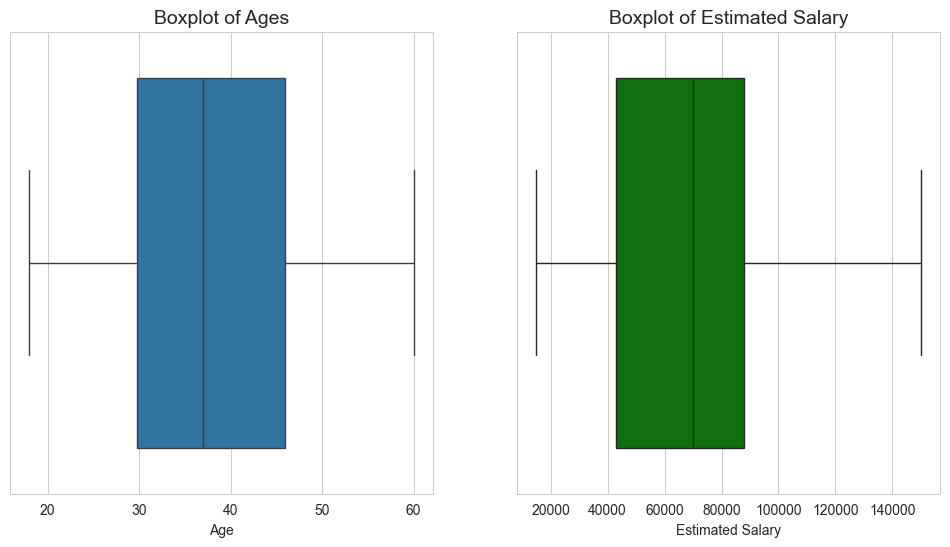

In [213]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Boxplot for Age Distribution (Detect Outliers)
sns.boxplot(x=df["Age"], ax=axes[0])
axes[0].set_title("Boxplot of Ages", fontsize=14)
axes[0].set_xlabel("Age")

# 2. Boxplot for Estimated Salary Distribution (Detect Outliers)
sns.boxplot(x=df["EstimatedSalary"], color="green", ax=axes[1])
axes[1].set_title("Boxplot of Estimated Salary", fontsize=14)
axes[1].set_xlabel("Estimated Salary")


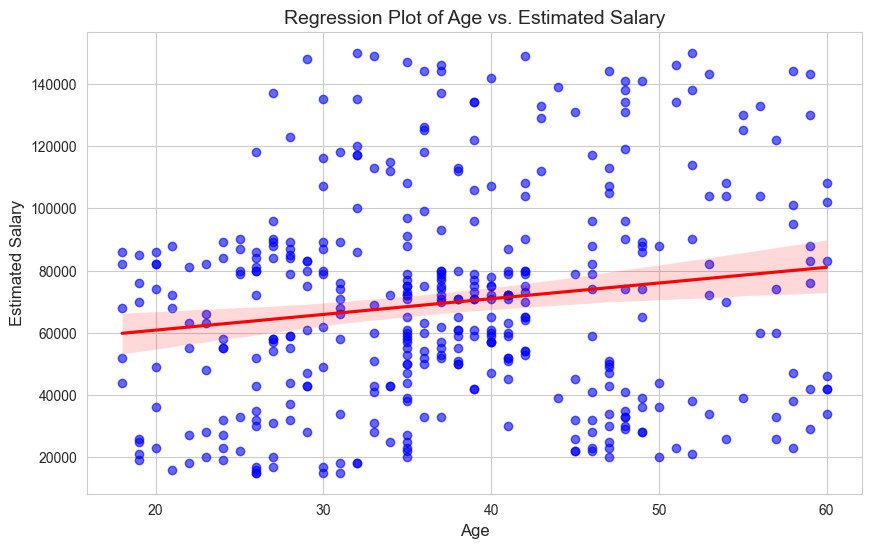

In [214]:
# Set plot style
sns.set_style("whitegrid")

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=df["Age"], y=df["EstimatedSalary"], color="blue", scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

# Titles and labels
plt.title("Regression Plot of Age vs. Estimated Salary", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Estimated Salary", fontsize=12)

# Show the plot
plt.show()


Existe uma correlação positiva fraca entre Idade e Salário.

A Idade, isoladamente, não é um forte preditor do Salário, como indicado pela ampla dispersão.

### Pré-processamento de Dados

**Tratando Variáveis Categóricas**
* A maioria dos modelos de aprendizado de máquina exige entradas numéricas, então precisamos converter variáveis categóricas em números.


**Verificando Tipos de Dados**

Primeiro, inspecionamos nosso conjunto de dados para identificar variáveis categóricas.
* df.dtypes


**Codificando Dados Categóricos**

Como os modelos não podem trabalhar diretamente com dados categóricos, devemos transformá-los em valores numéricos.
* Usaremos Label Encoding para categorias binárias (ex.: Masculino/Feminino).
* **from sklearn.preprocessing import LabelEncoder**

Essa transformação também é essencial para calcular matrizes de correlação, pois os coeficientes de correlação exigem valores numéricos.

In [215]:
#1
df.dtypes

Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [216]:
#2
#Right our only categorical data is the Gender column as a type object, lets transform it with Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer

# Function to transform Gender column
def label_encode_gender(df):
    encoder = LabelEncoder()
    df['Gender'] = encoder.fit_transform(df['Gender'])
    return df

# Create a pipeline with a custom transformer
pipeline = Pipeline([
    ('gender_label_encoding', FunctionTransformer(label_encode_gender))
])

# Transform the data
df_transformed = pipeline.fit_transform(df)
print(df_transformed)

     Gender  Age  EstimatedSalary  Purchased
0         1   19            19000          0
1         1   35            20000          0
2         0   26            43000          0
3         0   27            57000          0
4         1   19            76000          0
..      ...  ...              ...        ...
395       0   46            41000          1
396       1   51            23000          1
397       0   50            20000          1
398       1   36            33000          0
399       0   49            36000          1

[400 rows x 4 columns]


Agora que transformamos nosso valor categórico em numérico, também podemos ver o coeficiente de correlação entre nossas variáveis e o valor alvo.

In [217]:
for i in df.columns:
    coef = np.corrcoef(df[i], df["Purchased"])[0,1]
    if i != 'Purchased':
        print(f"Correlation Coefficient of {i} x Purchased: {coef:.3f}")
    else: 
        break

Correlation Coefficient of Gender x Purchased: -0.042
Correlation Coefficient of Age x Purchased: 0.622
Correlation Coefficient of EstimatedSalary x Purchased: 0.362


#### Mas espere, o coeficiente de correlação entre Gênero e Comprado é negativo e muito próximo de 0. Isso está correto?

Na verdade, está correto, e isso é uma informação valiosa para nós. Mas primeiro, vamos entender o que aconteceu:
* O coeficiente de correlação de Pearson (que é comumente usado) mede relações lineares entre duas variáveis. 
* Quando ambas as variáveis são binárias (0 e 1), **a correlação se torna uma medida de quão frequentemente elas coincidem ou diferem.**

    - Se a correlação for positiva, Gênero = 1 tem maior probabilidade de resultar em Alvo = 1.
    - Se a correlação for negativa, Gênero = 1 tem maior probabilidade de resultar em Alvo = 0.

**Resultados Chaves**
* Com uma correlação de -0.042, isso indica que Gênero não tem um impacto significativo sobre se uma pessoa realiza uma compra.
* Em outras palavras, **não há diferença significativa entre o comportamento de compra de homens e mulheres neste conjunto de dados.**


#### Ok, agora para o Modelo de Regressão Logística nós temos tudo que precisamos

1. Os dados são totalmente numéricos
2. Os dados estão devidamente limpos
3. Os dados não contêm valores nulos ou ausentes

#### Então, vamos começar a desenvolver nosso modelo

1. Separamos os valores de X e Y (Purchased).
2. Use o **train_test_split** para separar corretamente nossos dados em treino e teste.
3. Fit o modelo **Logistic Regression**, com os dados de treino.
4. Por fim, veja a pontuação do nosso modelo

In [218]:
#1
X = df.drop(columns = ['Purchased'], axis=1)
y = df['Purchased']

In [219]:
X.head()

,Gender,Age,EstimatedSalary
0,1,19,19000
1,1,35,20000
2,0,26,43000
3,0,27,57000
4,1,19,76000


In [220]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Purchased, dtype: int64

In [221]:
#2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42) 

In [222]:
#3
model = LogisticRegression(solver = 'liblinear', random_state = 42) #liblinear is good for small datasets
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [223]:
#4
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        52
           1       1.00      0.04      0.07        28

    accuracy                           0.66        80
   macro avg       0.83      0.52      0.43        80
weighted avg       0.78      0.66      0.54        80



Temos um grande problema aqui, a pontuação de recall para a classe 1 está muito baixa

A pontuação de recall da classe 1 nos indica que o modelo identificou apenas 4% das instâncias reais dessa classe.

**Mas isso pode ser corrigido, certo? Bem, podemos tentar**   

Para um melhor entendimento, essa classificação incorreta normalmente é causada por conjuntos de dados desproporcionais, onde uma classe possui muito mais dados do que a outra.

* Primeiro, vamos verificar os dados da variável **Purchased** para analisar sua proporção.


In [224]:
#1
df.Purchased.value_counts(1)

Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64

Bom, isso poderia ser pior. Temos 64% da classe 0 presente no conjunto de dados e 35% da classe 1.

Vamos tentar equilibrar essa proporção para 50/50 usando uma técnica chamada **SMOTE**, que gera dados para a classe que possui menos amostras.

* **from imblearn.over_sampling import SMOTE**

In [225]:
X = df.drop(columns = ['Purchased'], axis=1)
y = df['Purchased']

In [226]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

sm = SMOTE(random_state=42)

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)


Percebeu que aplicamos o **SMOTE** apenas após a função **train_test_split**?

Fizemos isso para evitar **vazamento de dados**, que pode ocorrer quando informações de fora do conjunto de treinamento são usadas para criar o modelo, o que pode ser um grande problema de desempenho.

Se aplicarmos o SMOTE **depois** do **train_test_split**:
* O modelo é treinado em um conjunto de dados balanceado.

* O conjunto de teste continua representando dados do mundo real, que geralmente são desbalanceados.

* A avaliação reflete com precisão como o modelo irá performar em dados não vistos.


Se aplicarmos o SMOTE **antes** do **train_test_split**:
* As amostras sintéticas são geradas usando informações de todo o conjunto de dados.

* Algumas dessas informações sintéticas (baseadas nos dados de teste) vazam para os dados de treinamento.

* O modelo vê dados derivados do conjunto de teste durante o treinamento, levando a:
    - Overfitting (superajuste)
    - Avaliação irrealista do desempenho (muito otimista)

In [ ]:
from collections import Counter
print("Class distribution antes resampling:", Counter(y_train))
print("Class distribution depois resampling:", Counter(y_train_SMOTE))

Class distribution before resampling: Counter({0: 205, 1: 115})
Class distribution after resampling: Counter({0: 205, 1: 205})


Após aplicar SMOTE, obtivemos uma proporção de 50/50, com 205 para a classe 0 e 205 para a classe 1.

Mas isso não é tudo. Podemos ter um problema com nossos dados ao trabalhar com **Regressão Logística**, que não está relacionado apenas à proporção das classes. Vamos analisar a distribuição dos dados nas colunas Age e EstimatedSalary.

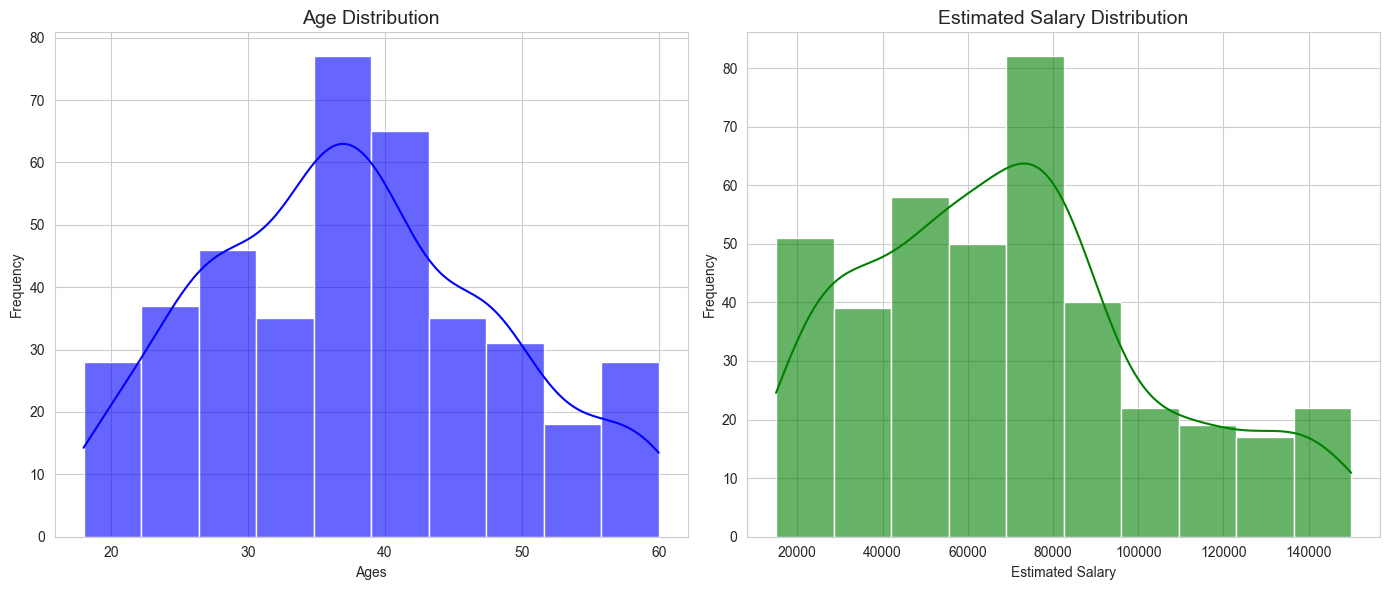

In [228]:
# Set plot style
sns.set_style("whitegrid")

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for Ages
sns.histplot(df["Age"], bins=10, kde=True, color="blue", alpha=0.6, ax=axes[0])
axes[0].set_title("Age Distribution", fontsize=14)
axes[0].set_xlabel("Ages")
axes[0].set_ylabel("Frequency")

# Histogram for Estimated Salary
sns.histplot(df["EstimatedSalary"], bins=10, kde=True, color="green", alpha=0.6, ax=axes[1])
axes[1].set_title("Estimated Salary Distribution", fontsize=14)
axes[1].set_xlabel("Estimated Salary")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

O que percebemos nesses gráficos é que temos dados com escalas muito diferentes. A distribuição de Age varia de **10 a 60**, enquanto os EstimatedSalary variam de **10.000 a 160.000.** Essas escalas são muito distintas entre si.

**Mas por que isso é um problema?**

Isso pode fazer com que o modelo interprete que EstimatedSalary é mais importante do que Age, priorizando apenas uma variável e tornando o processo de otimização desequilibrado e mais lento.

#### Por que é tão ruim ter os dados espalhados dessa forma?

Isso é problemático porque, no modelo de **Regressão Logística**, enfrentamos os seguintes desafios:

*  Problemas de Convergência do Gradiente Descendente
    - O algoritmo de otimização Gradiente Descendente funciona melhor quando todas as variáveis estão em uma **escala semelhante**.
    - Recursos em escalas muito grandes, como salários, podem fazer com que alguns pesos sejam atualizados muito mais rápido do que outros, tornando a convergência lenta ou até impedindo que o modelo alcance o mínimo global.

* Distorção da Importância das Variáveis
    - O modelo atribui coeficientes com base nos valores das variáveis.
    - Se uma variável, como **EstimatedSalary**, tem valores muito maiores do que outras, seu coeficiente também será desproporcionalmente maior, o que pode distorcer a real importância da variável no modelo.

**Como resolver esse problema?**

* Podemos usar o Standard Scaler do módulo sklearn.preprocessing para transformar os dados, garantindo que:

    - Média = 0
    - Desvio Padrão = 1
* Ao padronizar os dados, garantimos que todas as variáveis fiquem na mesma faixa de valores, evitando que alguma delas domine o modelo apenas por causa de sua escala (exemplo: EstimatedSalary sobre Age).

In [229]:
from sklearn.preprocessing import StandardScaler
# Define numeric and categorical columns
numeric_features = ['Age', 'EstimatedSalary']
gender_features = ['Gender']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Apply StandardScaler to numeric features
        ('cat', 'passthrough', gender_features)  # Leave Gender unchanged
    ]
)

# Create a pipeline with preprocessing and Logistic Regression
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear' ,random_state=42))
])

# Fit the pipeline with the training data from SMOTE
pipeline.fit(X_train_SMOTE, y_train_SMOTE)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

In [230]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        52
           1       0.80      0.86      0.83        28

    accuracy                           0.88        80
   macro avg       0.86      0.87      0.86        80
weighted avg       0.88      0.88      0.88        80



#### Bem Melhor!

Ao padronizar os dados, observamos uma melhoria significativa no desempenho da classificação do nosso modelo. Isso destaca a importância de ter um conjunto de dados bem equilibrado, com valores que seguem uma escala consistente.

### Para melhorar

1. Descobrimos que o gênero tem um Coeficiente de Correlação de **-0.042**, um valor bastante baixo. Então podemos remover a coluna **Gender** e ter resulrados melhores?
2. Adicionar uma Pipeline no nosso primeiro modelo, para melhorar o código.
3. Experimente este conjunto de dados em outros algoritmos.